# Workout Recommendation Model

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')


In [6]:
data_path = r"D:\Projects\SmartFit-SmartDiet\data\processed\pamap2_features_clustered.csv"
df = pd.read_csv(data_path)
print("Data shape:", df.shape)
df.head()


Data shape: (690, 483)


,timestamp_mean,timestamp_std,timestamp_min,timestamp_max,timestamp_median,timestamp_kurtosis,timestamp_skew,timestamp_energy,timestamp_dom_freq,heart_rate_mean,...,extra_col_54_kurtosis,extra_col_54_skew,extra_col_54_energy,extra_col_54_dom_freq,subject_id,session_type,window_start,window_end,activity,kmeans_cluster
0,37.74314,16.047300,10.03,65.39,37.825,-1.204632,-0.009388,1682.060455,0.390625,112.142,...,NaN,NaN,0.0,0.0,101,optional,1970-01-01 00:00:10.030,1970-01-01 00:01:05.390,NaN,2
1,93.06666,15.847266,65.50,120.42,93.025,-1.200776,-0.001697,8912.539050,0.390625,113.582,...,NaN,NaN,0.0,0.0,101,optional,1970-01-01 00:01:05.500,1970-01-01 00:02:00.420,NaN,2
2,148.14500,16.099049,120.53,175.88,147.935,-1.217297,0.009092,22206.120412,0.390625,114.332,...,NaN,NaN,0.0,0.0,101,optional,1970-01-01 00:02:00.530,1970-01-01 00:02:55.880,NaN,2
3,203.30376,15.789988,175.99,230.59,203.305,-1.199326,-0.000588,41581.742563,0.390625,121.434,...,NaN,NaN,0.0,0.0,101,optional,1970-01-01 00:02:55.990,1970-01-01 00:03:50.590,car_driving,2
4,257.99310,15.786906,230.70,285.28,257.995,-1.200005,-0.000010,66809.666057,0.390625,110.098,...,NaN,NaN,0.0,0.0,101,optional,1970-01-01 00:03:50.700,1970-01-01 00:04:45.280,car_driving,2


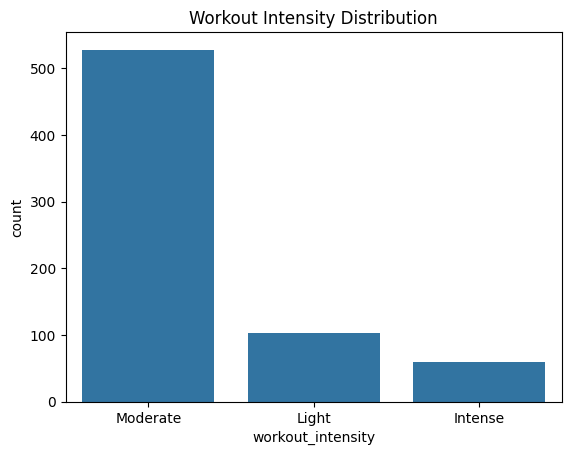

In [7]:
# Map activity into intensity groups (example)
intensity_map = {
    "lying": "Light", "sitting": "Light", "standing": "Light",
    "walking": "Moderate", "cycling": "Moderate",
    "running": "Intense", "nordic_walking": "Intense", "playing_soccer": "Intense",
    # Map other activities as needed, default to Moderate
}

df['workout_intensity'] = df['activity'].map(intensity_map).fillna("Moderate")

# Check distribution
sns.countplot(x='workout_intensity', data=df)
plt.title("Workout Intensity Distribution")
plt.show()


In [ ]:
# Drop non-feature columns except target
non_feature_cols = ['subject_id', 'session_type', 'window_start', 'window_end', 'activity', 'kmeans_cluster', 'workout_intensity']
X = df.drop(columns=non_feature_cols)
y = df['workout_intensity']

print("Features shape:", X.shape)
print("Target distribution:")
print(y.value_counts())

Features shape: (690, 477)
Target distribution:
workout_intensity
Moderate    528
Light       103
Intense      59
Name: count, dtype: int64


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (552, 477), Test shape: (138, 477)


In [10]:
# Optional scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [11]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

     Intense       1.00      1.00      1.00        12
       Light       1.00      0.76      0.86        21
    Moderate       0.95      1.00      0.98       105

    accuracy                           0.96       138
   macro avg       0.98      0.92      0.95       138
weighted avg       0.97      0.96      0.96       138



In [20]:
# Initialize model
lgbm = LGBMClassifier(
    objective='multiclass',
    num_class=len(y.unique()),
    random_state=42,
    n_estimators=100
)

# Fit without early stopping
lgbm.fit(X_train, y_train)

# Predict and evaluate
y_pred_lgbm = lgbm.predict(X_test)

print("LightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgbm))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76051
[LightGBM] [Info] Number of data points in the train set: 552, number of used features: 476
[LightGBM] [Info] Start training from score -2.463400
[LightGBM] [Info] Start training from score -1.906829
[LightGBM] [Info] Start training from score -0.266176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [21]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print(f"Best params RF: {grid_rf.best_params_}")
best_rf = grid_rf.best_estimator_

y_pred_best_rf = best_rf.predict(X_test)
print("Tuned Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf))


Best params RF: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Tuned Random Forest Classification Report:
              precision    recall  f1-score   support

     Intense       1.00      1.00      1.00        12
       Light       1.00      0.76      0.86        21
    Moderate       0.95      1.00      0.98       105

    accuracy                           0.96       138
   macro avg       0.98      0.92      0.95       138
weighted avg       0.97      0.96      0.96       138



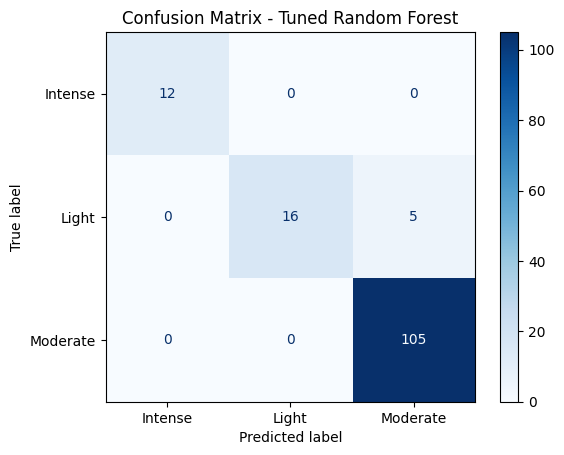

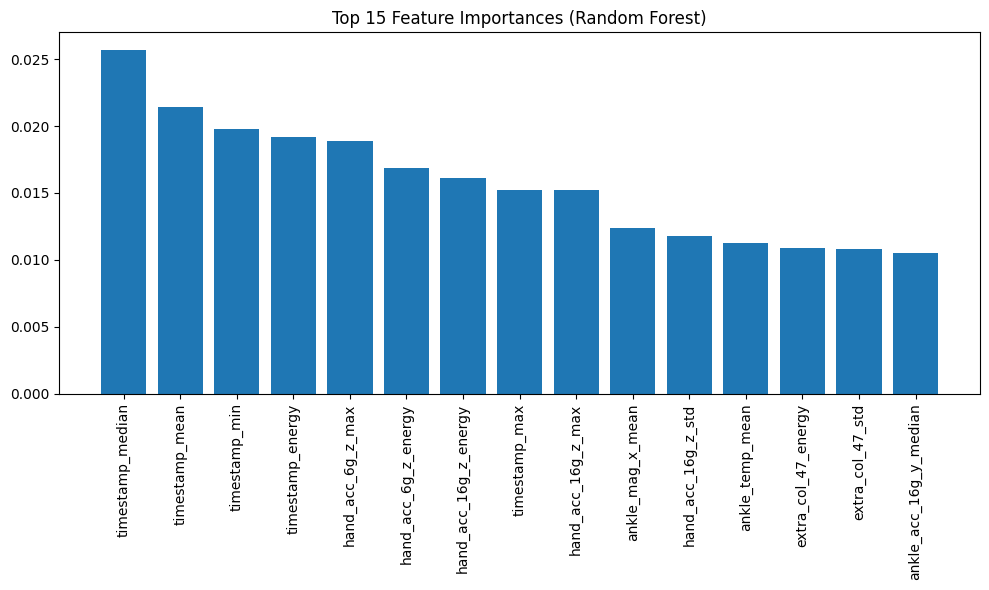

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix for tuned RF
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Tuned Random Forest")
plt.show()

# Feature importance
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 15

plt.figure(figsize=(10,6))
plt.title("Top 15 Feature Importances (Random Forest)")
plt.bar(range(top_n), importances[indices][:top_n], align='center')
plt.xticks(range(top_n), X.columns[indices][:top_n], rotation=90)
plt.tight_layout()
plt.show()


In [26]:
import joblib
import os

model_dir = r"D:\Projects\SmartFit-SmartDiet\models"
os.makedirs(model_dir, exist_ok=True)

joblib.dump(best_rf, os.path.join(model_dir, 'best_rf_workout_model.joblib'))
joblib.dump(scaler, os.path.join(model_dir, 'scaler_workout.pkl'))
print("Saved tuned Random Forest model and scaler.")


Saved tuned Random Forest model and scaler.
